In [2]:
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [48]:
# Define file paths
train_csv = "/content/drive/MyDrive/Colab_Notebooks/dataset/train.csv"
test_csv = "/content/drive/MyDrive/Colab_Notebooks/dataset/test.csv"

# Load CSV files
train = pd.read_csv(train_csv, usecols=["image_ID", "label"])
test = pd.read_csv(test_csv, usecols=["image_ID"])

# Display shapes of train and test datasets
print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (8227, 2)
Test shape: (2056, 1)


In [49]:
image_to_label_map = dict(zip(train["image_ID"].values, train["label"].values))

unique_classes = train["label"].unique()
print("Unique classes:", unique_classes)
print("Number of unique classes:", len(unique_classes))

Unique classes: ['Badminton' 'Cricket' 'Tennis' 'Swimming' 'Soccer' 'Wrestling' 'Karate']
Number of unique classes: 7


<Axes: xlabel='label', ylabel='count'>

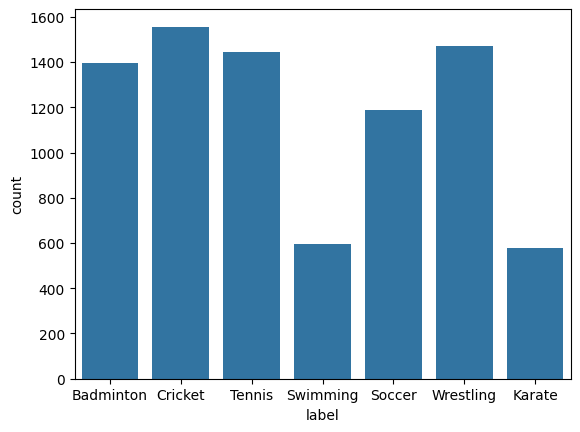

In [50]:
import seaborn as sns

sns.countplot(data=train, x="label")

In [51]:
label_counts = train["label"].value_counts()
print(label_counts)

label
Cricket      1556
Wrestling    1471
Tennis       1445
Badminton    1394
Soccer       1188
Swimming      595
Karate        578
Name: count, dtype: int64


In [52]:
from PIL import Image
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast
from torch.amp import GradScaler, autocast
from tqdm import tqdm

# Resnet50
# Dataset class for loading images and labels
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, is_test=False):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)

        if self.is_test or "label" not in self.dataframe.columns:
            return image  # No label available for test data
        label = torch.tensor(self.dataframe.iloc[idx, 1], dtype=torch.long)
        return image, label


In [53]:
# 2. Split Data into Train and Validation Sets
train['label'] = pd.Categorical(train['label']).codes
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)  # 80-20 split

# 3. Define Image Transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 4. Define Image Directory Paths
train_img_dir = "/content/drive/MyDrive/Colab_Notebooks/dataset/train/"
test_img_dir = "/content/drive/MyDrive/Colab_Notebooks/dataset/test/"

# 5. Create Datasets and Dataloaders
train_dataset = CustomImageDataset(train_df, train_img_dir, transform=transform)
val_dataset = CustomImageDataset(val_df, train_img_dir, transform=transform)  # Same dir if validation images are in `train`
test_dataset = CustomImageDataset(test, test_img_dir, transform=transform, is_test=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# 6. Model Setup
num_classes = len(train["label"].unique())
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjusting last layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 7. Loss Function, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [54]:
# Initialize GradScaler with updated syntax
scaler = GradScaler()

num_epochs = 5  # Set number of epochs

# Initialize lists to store metrics for each epoch
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training...")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Calculate accuracy and loss for the training epoch
    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    # Calculate accuracy and loss for the validation epoch
    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_model.pth")
        print("Model saved!")

# End of training
print("Training completed.")

Start training...


Epoch 1/5 - Training: 100%|██████████| 206/206 [00:24<00:00,  8.47it/s]


Epoch [1/5], Training Loss: 1.0736, Training Accuracy: 0.6294


Epoch 1/5 - Validation: 100%|██████████| 52/52 [00:05<00:00,  9.03it/s]


Epoch [1/5], Validation Loss: 0.7579, Validation Accuracy: 0.7266


Epoch 2/5 - Training: 100%|██████████| 206/206 [00:24<00:00,  8.52it/s]


Epoch [2/5], Training Loss: 0.6903, Training Accuracy: 0.7696


Epoch 2/5 - Validation: 100%|██████████| 52/52 [00:05<00:00,  8.88it/s]


Epoch [2/5], Validation Loss: 0.6713, Validation Accuracy: 0.7643


Epoch 3/5 - Training: 100%|██████████| 206/206 [00:24<00:00,  8.57it/s]


Epoch [3/5], Training Loss: 0.5470, Training Accuracy: 0.8139


Epoch 3/5 - Validation: 100%|██████████| 52/52 [00:06<00:00,  8.37it/s]


Epoch [3/5], Validation Loss: 0.5808, Validation Accuracy: 0.8032


Epoch 4/5 - Training: 100%|██████████| 206/206 [00:24<00:00,  8.52it/s]


Epoch [4/5], Training Loss: 0.4236, Training Accuracy: 0.8604


Epoch 4/5 - Validation: 100%|██████████| 52/52 [00:06<00:00,  8.61it/s]


Epoch [4/5], Validation Loss: 0.5478, Validation Accuracy: 0.8001


Epoch 5/5 - Training: 100%|██████████| 206/206 [00:24<00:00,  8.55it/s]


Epoch [5/5], Training Loss: 0.3361, Training Accuracy: 0.8865


Epoch 5/5 - Validation: 100%|██████████| 52/52 [00:05<00:00,  8.82it/s]

Epoch [5/5], Validation Loss: 0.5671, Validation Accuracy: 0.8135
Training completed.


Epoch [5/5], Training Loss: 0.3478, Training Accuracy: 0.8865


In [38]:
# VGG

num_classes = len(train["label"].unique())

# Load VGG16 with pre-trained weights and modify the classifier layer
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Adjust the final layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 7. Define Loss Function, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Initialize GradScaler for mixed precision training
scaler = GradScaler()

num_epochs = 5  # Set the number of epochs
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training with VGG16...")

# 8. Training Loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_vgg16_model.pth")
        print("Model saved!")

print("Training with VGG16 completed.")

Start training with VGG16...


Epoch 1/5 - Training: 100%|██████████| 206/206 [00:24<00:00,  8.33it/s]


Epoch [1/5], Training Loss: 1.9279, Training Accuracy: 0.1816


Epoch 1/5 - Validation: 100%|██████████| 52/52 [00:05<00:00,  8.68it/s]


Epoch [1/5], Validation Loss: 1.8902, Validation Accuracy: 0.1701


Epoch 2/5 - Training: 100%|██████████| 206/206 [00:24<00:00,  8.40it/s]


Epoch [2/5], Training Loss: 1.8952, Training Accuracy: 0.1798


Epoch 2/5 - Validation: 100%|██████████| 52/52 [00:06<00:00,  8.44it/s]


Epoch [2/5], Validation Loss: 1.8838, Validation Accuracy: 0.1744


Epoch 3/5 - Training: 100%|██████████| 206/206 [00:24<00:00,  8.38it/s]


Epoch [3/5], Training Loss: 1.8918, Training Accuracy: 0.1747


Epoch 3/5 - Validation: 100%|██████████| 52/52 [00:06<00:00,  8.42it/s]


Epoch [3/5], Validation Loss: 1.8878, Validation Accuracy: 0.1847


Epoch 4/5 - Training: 100%|██████████| 206/206 [00:24<00:00,  8.49it/s]


Epoch [4/5], Training Loss: 1.8932, Training Accuracy: 0.1871


Epoch 4/5 - Validation: 100%|██████████| 52/52 [00:06<00:00,  8.30it/s]


Epoch [4/5], Validation Loss: 1.8871, Validation Accuracy: 0.1847


Epoch 5/5 - Training: 100%|██████████| 206/206 [00:24<00:00,  8.43it/s]


Epoch [5/5], Training Loss: 1.8923, Training Accuracy: 0.1819


Epoch 5/5 - Validation: 100%|██████████| 52/52 [00:06<00:00,  8.34it/s]

Epoch [5/5], Validation Loss: 1.8871, Validation Accuracy: 0.1744
Training with VGG16 completed.


In [39]:
num_classes = len(train["label"].unique())

# Load GoogLeNet with pre-trained weights and modify the final layer
model = models.googlenet(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust final fully connected layer

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scaler = GradScaler()  # Mixed precision training

# Training loop remains the same as in your existing code
num_epochs = 5
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training with GoogLeNet...")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_googlenet_model.pth")
        print("Model saved!")

print("Training with GoogLeNet completed.")

Start training with GoogLeNet...


Epoch 1/5 - Training: 100%|██████████| 206/206 [00:24<00:00,  8.54it/s]


Epoch [1/5], Training Loss: 0.6288, Training Accuracy: 0.7864


Epoch 1/5 - Validation: 100%|██████████| 52/52 [00:06<00:00,  8.37it/s]


Epoch [1/5], Validation Loss: 0.4987, Validation Accuracy: 0.8348


Epoch 2/5 - Training: 100%|██████████| 206/206 [00:24<00:00,  8.42it/s]


Epoch [2/5], Training Loss: 0.3434, Training Accuracy: 0.8804


Epoch 2/5 - Validation: 100%|██████████| 52/52 [00:06<00:00,  8.47it/s]


Epoch [2/5], Validation Loss: 0.3662, Validation Accuracy: 0.8809


Epoch 3/5 - Training: 100%|██████████| 206/206 [00:24<00:00,  8.35it/s]


Epoch [3/5], Training Loss: 0.2747, Training Accuracy: 0.9082


Epoch 3/5 - Validation: 100%|██████████| 52/52 [00:06<00:00,  8.44it/s]


Epoch [3/5], Validation Loss: 0.5664, Validation Accuracy: 0.8275


Epoch 4/5 - Training: 100%|██████████| 206/206 [00:25<00:00,  8.20it/s]


Epoch [4/5], Training Loss: 0.1863, Training Accuracy: 0.9410


Epoch 4/5 - Validation: 100%|██████████| 52/52 [00:05<00:00,  8.99it/s]


Epoch [4/5], Validation Loss: 0.4443, Validation Accuracy: 0.8572


Epoch 5/5 - Training: 100%|██████████| 206/206 [00:25<00:00,  8.21it/s]


Epoch [5/5], Training Loss: 0.1320, Training Accuracy: 0.9562


Epoch 5/5 - Validation: 100%|██████████| 52/52 [00:05<00:00,  8.81it/s]

Epoch [5/5], Validation Loss: 0.3440, Validation Accuracy: 0.9028
Training with GoogLeNet completed.


In [40]:
# AlexNet

# Set the number of classes for the final layer
num_classes = len(train["label"].unique())

# Load AlexNet with pre-trained weights and adjust the classifier for the number of classes
model = models.alexnet(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Modify final fully connected layer

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scaler = GradScaler()  # For mixed precision training

# Initialize lists to store metrics
num_epochs = 5
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training with AlexNet...")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Calculate accuracy and loss for the training epoch
    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_alexnet_model.pth")
        print("Model saved!")

print("Training with AlexNet completed.")

Start training with AlexNet...


Epoch 1/5 - Training: 100%|██████████| 206/206 [00:24<00:00,  8.47it/s]


Epoch [1/5], Training Loss: 1.9213, Training Accuracy: 0.1887


Epoch 1/5 - Validation: 100%|██████████| 52/52 [00:05<00:00,  8.88it/s]


Epoch [1/5], Validation Loss: 1.9046, Validation Accuracy: 0.1744


Epoch 2/5 - Training: 100%|██████████| 206/206 [00:24<00:00,  8.54it/s]


Epoch [2/5], Training Loss: 1.8903, Training Accuracy: 0.1817


Epoch 2/5 - Validation: 100%|██████████| 52/52 [00:05<00:00,  8.82it/s]


Epoch [2/5], Validation Loss: 1.8880, Validation Accuracy: 0.1744


Epoch 3/5 - Training: 100%|██████████| 206/206 [00:24<00:00,  8.32it/s]


Epoch [3/5], Training Loss: 1.8914, Training Accuracy: 0.1752


Epoch 3/5 - Validation: 100%|██████████| 52/52 [00:06<00:00,  8.64it/s]


Epoch [3/5], Validation Loss: 1.8908, Validation Accuracy: 0.1701


Epoch 4/5 - Training: 100%|██████████| 206/206 [00:24<00:00,  8.54it/s]


Epoch [4/5], Training Loss: 1.8898, Training Accuracy: 0.1877


Epoch 4/5 - Validation: 100%|██████████| 52/52 [00:05<00:00,  8.69it/s]


Epoch [4/5], Validation Loss: 1.8864, Validation Accuracy: 0.1744


Epoch 5/5 - Training: 100%|██████████| 206/206 [00:24<00:00,  8.52it/s]


Epoch [5/5], Training Loss: 1.8890, Training Accuracy: 0.1807


Epoch 5/5 - Validation: 100%|██████████| 52/52 [00:05<00:00,  8.73it/s]

Epoch [5/5], Validation Loss: 1.8870, Validation Accuracy: 0.1847
Training with AlexNet completed.


Epoch [5/5], Training Loss: 1.8894, Training Accuracy: 0.1887 -> AlexNet  
Epoch [5/5], Training Loss: 0.1740, Training Accuracy: 0.9418-> googlenet  
Epoch [5/5], Training Loss: 1.1477, Training Accuracy: 0.5821 -> VGG16  
Epoch [5/5], Training Loss: 0.3478, Training Accuracy: 0.8800 -> Resnet50  

The dataset is probably very high in variability of features, moderately to greatly large in size with a great number of classes, and high-resolution images. The better performance by GoogLeNet and ResNet50 hints at complex and subtle patterns within the dataset that simpler models like AlexNet can't match.  

The dataset size is probably moderate to large: usually, the deeper models, like GoogLeNet and ResNet50, perform better when they have more data, which improves when using pre-trained weights. Similarly, the number of classes is probably big because, in this case, models like GoogLeNet handle the diversity among classes well, whereas AlexNet usually suffers in the multi-class environment.  

Finally, the dataset most likely contains high-resolution images (224x224 pixels or larger), as GoogLeNet and ResNet50 rely on detailed spatial information to distinguish complex features; this resolution allows deeper models to capture class-specific details—suggesting that GoogLeNet and ResNet50 would really be among the best choices for this dataset.  



In [50]:
import os
import uuid
import cv2
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from torchvision import transforms
import random
from torch import nn

# SRCNN Model Definition
class SRCNN(nn.Module):
    def __init__(self, kernel_list=[9, 3, 5], filters_list=[128, 64, 3]):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, filters_list[0], kernel_list[0], padding=kernel_list[0] // 2)
        self.conv2 = nn.Conv2d(filters_list[0], filters_list[1], kernel_list[1], padding=kernel_list[1] // 2)
        self.conv3 = nn.Conv2d(filters_list[1], filters_list[2], kernel_list[2], padding=kernel_list[2] // 2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.conv3(x)
        return x

# Load SRCNN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
srcnn_model = SRCNN().to(device)

try:
    srcnn_model.load_state_dict(torch.load("srcnn_model.pth", map_location=device))
    srcnn_model.eval()
except FileNotFoundError:
    print("Model file 'srcnn_model.pth' not found. Using an untrained model.")
    srcnn_model.eval()

# Function to apply SRCNN for augmentation
def augment_with_srcnn(srcnn_model, image_path, upscale_factor=3):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Image at path '{image_path}' could not be loaded.")
        return None
    img = img.astype(np.float32) / 255.0
    h, w = img.shape[:2]
    if h < upscale_factor or w < upscale_factor:
        print(f"Image too small for upscale: {image_path} (h={h}, w={w})")
        return None
    lr_img = cv2.resize(img, (w // upscale_factor, h // upscale_factor), interpolation=cv2.INTER_AREA)
    lr_img = cv2.resize(lr_img, (w, h), interpolation=cv2.INTER_CUBIC)
    lr_tensor = torch.tensor(lr_img.transpose(2, 0, 1)).unsqueeze(0).to(device)
    with torch.no_grad():
        sr_tensor = srcnn_model(lr_tensor)
    sr_img = sr_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
    return (sr_img * 255).astype(np.uint8)

# Load dataset CSV
data_path = "/content/drive/MyDrive/Colab_Notebooks/dataset/train.csv"
data = pd.read_csv(data_path)

# Set the target count to match the maximum count of any class
target_count = data['label'].value_counts().max()
print("Target count for balancing:", target_count)

# Directory to save augmented images
output_dir = "/content/drive/MyDrive/Colab_Notebooks/dataset/augmented"
os.makedirs(output_dir, exist_ok=True)

# Augment each class to reach target count
for label in data['label'].unique():
    class_data = data[data['label'] == label]
    class_images = class_data['image_ID'].tolist()
    class_count = len(class_images)
    class_output_dir = os.path.join(output_dir, label)
    os.makedirs(class_output_dir, exist_ok=True)

    if class_count < target_count:
        print(f"Augmenting class '{label}' from {class_count} to {target_count}")
        aug_counter = 0
        new_rows = []
        max_attempts = 15000
        attempts = 0

        while len(class_images) < target_count and attempts < max_attempts:
            attempts += 1
            img_id = random.choice(class_images)
            img_path = os.path.join("/content/drive/MyDrive/Colab_Notebooks/dataset/train", img_id)
            if not os.path.exists(img_path):
                print(f"File not found: {img_path}")
                continue

            aug_img = augment_with_srcnn(srcnn_model, img_path)
            if aug_img is None:
                continue

            new_img_id = f"{uuid.uuid4().hex[:8]}.jpg"
            new_img_path = os.path.join(class_output_dir, new_img_id)
            if not cv2.imwrite(new_img_path, aug_img):
                print(f"Failed to save image: {new_img_path}")
                continue

            class_images.append(new_img_id)
            new_rows.append({"image_ID": new_img_id, "label": label})
            aug_counter += 1

        data = pd.concat([data, pd.DataFrame(new_rows)], ignore_index=True)

# Save the balanced dataset
balanced_data_path = "/content/drive/MyDrive/Colab_Notebooks/dataset/balanced_train.csv"
data.to_csv(balanced_data_path, index=False)
print("Balanced dataset saved to", balanced_data_path)


<ipython-input-50-b59eb9accdd5>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  srcnn_model.load_state_dict(torch.load("srcnn_model.pth", map_location=device))


Model file 'srcnn_model.pth' not found. Using an untrained model.
Target count for balancing: 1556
Augmenting class 'Badminton' from 1394 to 1556
File not found: /content/drive/MyDrive/Colab_Notebooks/dataset/train/a792df01.jpg
File not found: /content/drive/MyDrive/Colab_Notebooks/dataset/train/39745157.jpg
File not found: /content/drive/MyDrive/Colab_Notebooks/dataset/train/3021dbb7.jpg
File not found: /content/drive/MyDrive/Colab_Notebooks/dataset/train/c045cbb3.jpg
File not found: /content/drive/MyDrive/Colab_Notebooks/dataset/train/aca8c3da.jpg
File not found: /content/drive/MyDrive/Colab_Notebooks/dataset/train/b5139d26.jpg
File not found: /content/drive/MyDrive/Colab_Notebooks/dataset/train/341bb6c1.jpg
File not found: /content/drive/MyDrive/Colab_Notebooks/dataset/train/68ed43b2.jpg
File not found: /content/drive/MyDrive/Colab_Notebooks/dataset/train/7d2ab531.jpg
File not found: /content/drive/MyDrive/Colab_Notebooks/dataset/train/ef770e13.jpg
File not found: /content/drive/MyD

In [55]:
# Define file paths
balanced_train_csv = "/content/drive/MyDrive/Colab_Notebooks/dataset/balanced_train.csv"

balanced_train = pd.read_csv(balanced_train_csv, usecols=["image_ID", "label"])

print("Balanced Train shape:", balanced_train.shape)
image_to_label_map = dict(zip(balanced_train["image_ID"].values, balanced_train["label"].values))

Balanced Train shape: (10892, 2)


In [56]:
unique_classes1 = balanced_train["label"].unique()
print("Unique classes:", unique_classes1)
print("Number of unique classes:", len(unique_classes1))

Unique classes: ['Badminton' 'Cricket' 'Tennis' 'Swimming' 'Soccer' 'Wrestling' 'Karate']
Number of unique classes: 7


label
Badminton    1556
Cricket      1556
Tennis       1556
Swimming     1556
Soccer       1556
Wrestling    1556
Karate       1556
Name: count, dtype: int64


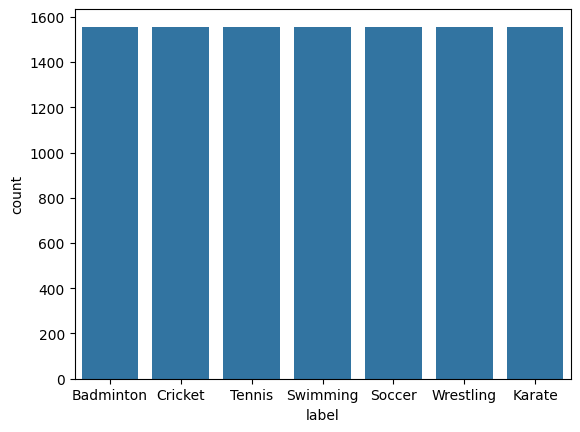

In [57]:
import seaborn as sns

sns.countplot(data=balanced_train, x="label")
label_counts = balanced_train["label"].value_counts()
print(label_counts)

In [62]:
from PIL import Image
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast
from torch.amp import GradScaler, autocast
from tqdm import tqdm

# Resnet50
# Dataset class for loading images and labels
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, is_test=False):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)

        if self.is_test or "label" not in self.dataframe.columns:
            return image  # No label available for test data
        label = torch.tensor(self.dataframe.iloc[idx, 1], dtype=torch.long)
        return image, label

In [63]:
# 2. Split Data into Train and Validation Sets
balanced_train['label'] = pd.Categorical(balanced_train['label']).codes
B_train_df, B_val_df = train_test_split(balanced_train, test_size=0.2, random_state=42)  # 80-20 split

# 3. Define Image Transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 4. Define Image Directory Paths
B_train_img_dir = "/content/drive/MyDrive/Colab_Notebooks/dataset/balanced_train"
test_img_dir = "/content/drive/MyDrive/Colab_Notebooks/dataset/test"

# 5. Create Datasets and Dataloaders
B_train_dataset = CustomImageDataset(B_train_df, B_train_img_dir, transform=transform)
B_val_dataset = CustomImageDataset(B_val_df, B_train_img_dir, transform=transform)
test_dataset = CustomImageDataset(test, test_img_dir, transform=transform, is_test=True)

B_train_loader = DataLoader(B_train_dataset, batch_size=32, shuffle=True, num_workers=4)
B_val_loader = DataLoader(B_val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test, batch_size=32, shuffle=False, num_workers=4)

# 6. Model Setup
num_classes = len(balanced_train["label"].unique())
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjusting last layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 7. Loss Function, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [64]:
# Initialize GradScaler with updated syntax
scaler = GradScaler()

num_epochs = 5  # Set number of epochs

# Initialize lists to store metrics for each epoch
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training with Resnet50")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(B_train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Calculate accuracy and loss for the training epoch
    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(B_val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    # Calculate accuracy and loss for the validation epoch
    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_model.pth")
        print("Model saved!")

# End of training
print("Training completed.")

Start training with Resnet50


Epoch 1/5 - Training: 100%|██████████| 273/273 [00:31<00:00,  8.74it/s]


Epoch [1/5], Training Loss: 1.2366, Training Accuracy: 0.5588


Epoch 1/5 - Validation: 100%|██████████| 69/69 [00:08<00:00,  8.47it/s]


Epoch [1/5], Validation Loss: 1.1260, Validation Accuracy: 0.6251


Epoch 2/5 - Training: 100%|██████████| 273/273 [00:31<00:00,  8.77it/s]


Epoch [2/5], Training Loss: 0.9039, Training Accuracy: 0.6774


Epoch 2/5 - Validation: 100%|██████████| 69/69 [00:08<00:00,  8.45it/s]


Epoch [2/5], Validation Loss: 0.8845, Validation Accuracy: 0.6856


Epoch 3/5 - Training: 100%|██████████| 273/273 [00:30<00:00,  8.90it/s]


Epoch [3/5], Training Loss: 0.7256, Training Accuracy: 0.7407


Epoch 3/5 - Validation: 100%|██████████| 69/69 [00:08<00:00,  8.55it/s]


Epoch [3/5], Validation Loss: 0.8563, Validation Accuracy: 0.7081


Epoch 4/5 - Training: 100%|██████████| 273/273 [00:30<00:00,  8.93it/s]


Epoch [4/5], Training Loss: 0.6048, Training Accuracy: 0.7921


Epoch 4/5 - Validation: 100%|██████████| 69/69 [00:08<00:00,  8.43it/s]


Epoch [4/5], Validation Loss: 0.6848, Validation Accuracy: 0.7604


Epoch 5/5 - Training: 100%|██████████| 273/273 [00:30<00:00,  8.87it/s]


Epoch [5/5], Training Loss: 0.4977, Training Accuracy: 0.8269


Epoch 5/5 - Validation: 100%|██████████| 69/69 [00:08<00:00,  8.23it/s]

Epoch [5/5], Validation Loss: 0.5675, Validation Accuracy: 0.8077
Training completed.


In [32]:
# VGG

num_classes = len(balanced_train["label"].unique())

# Load VGG16 with pre-trained weights and modify the classifier layer
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Adjust the final layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 7. Define Loss Function, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Initialize GradScaler for mixed precision training
scaler = GradScaler()

num_epochs = 5  # Set the number of epochs
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training with VGG16...")

# 8. Training Loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(B_train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(B_val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_vgg16_model.pth")
        print("Model saved!")

print("Training with VGG16 completed.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Start training with VGG16...


Epoch 1/5 - Training: 100%|██████████| 273/273 [00:31<00:00,  8.66it/s]


Epoch [1/5], Training Loss: 1.8187, Training Accuracy: 0.2740


Epoch 1/5 - Validation: 100%|██████████| 69/69 [00:08<00:00,  8.10it/s]


Epoch [1/5], Validation Loss: 1.5865, Validation Accuracy: 0.3391


Epoch 2/5 - Training: 100%|██████████| 273/273 [00:31<00:00,  8.72it/s]


Epoch [2/5], Training Loss: 1.5545, Training Accuracy: 0.3868


Epoch 2/5 - Validation: 100%|██████████| 69/69 [00:08<00:00,  8.49it/s]


Epoch [2/5], Validation Loss: 1.5763, Validation Accuracy: 0.3644


Epoch 3/5 - Training: 100%|██████████| 273/273 [00:31<00:00,  8.72it/s]


Epoch [3/5], Training Loss: 1.5415, Training Accuracy: 0.3952


Epoch 3/5 - Validation: 100%|██████████| 69/69 [00:08<00:00,  7.99it/s]


Epoch [3/5], Validation Loss: 1.4625, Validation Accuracy: 0.4121


Epoch 4/5 - Training: 100%|██████████| 273/273 [00:31<00:00,  8.68it/s]


Epoch [4/5], Training Loss: 1.4784, Training Accuracy: 0.4273


Epoch 4/5 - Validation: 100%|██████████| 69/69 [00:08<00:00,  8.06it/s]


Epoch [4/5], Validation Loss: 1.5685, Validation Accuracy: 0.3993


Epoch 5/5 - Training: 100%|██████████| 273/273 [00:31<00:00,  8.54it/s]


Epoch [5/5], Training Loss: 1.4607, Training Accuracy: 0.4436


Epoch 5/5 - Validation: 100%|██████████| 69/69 [00:08<00:00,  8.28it/s]

Epoch [5/5], Validation Loss: 1.4600, Validation Accuracy: 0.4052
Training with VGG16 completed.


In [33]:
num_classes = len(balanced_train["label"].unique())

# Load GoogLeNet with pre-trained weights and modify the final layer
model = models.googlenet(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust final fully connected layer

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scaler = GradScaler()  # Mixed precision training

# Training loop remains the same as in your existing code
num_epochs = 5
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training with GoogLeNet...")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(B_train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(B_val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_googlenet_model.pth")
        print("Model saved!")

print("Training with GoogLeNet completed.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Start training with GoogLeNet...


Epoch 1/5 - Training: 100%|██████████| 273/273 [00:32<00:00,  8.50it/s]


Epoch [1/5], Training Loss: 0.8228, Training Accuracy: 0.7120


Epoch 1/5 - Validation: 100%|██████████| 69/69 [00:08<00:00,  8.15it/s]


Epoch [1/5], Validation Loss: 0.6679, Validation Accuracy: 0.7742


Epoch 2/5 - Training: 100%|██████████| 273/273 [00:32<00:00,  8.41it/s]


Epoch [2/5], Training Loss: 0.5278, Training Accuracy: 0.8222


Epoch 2/5 - Validation: 100%|██████████| 69/69 [00:08<00:00,  7.97it/s]


Epoch [2/5], Validation Loss: 0.5099, Validation Accuracy: 0.8192


Epoch 3/5 - Training: 100%|██████████| 273/273 [00:32<00:00,  8.46it/s]


Epoch [3/5], Training Loss: 0.4032, Training Accuracy: 0.8592


Epoch 3/5 - Validation: 100%|██████████| 69/69 [00:08<00:00,  8.13it/s]


Epoch [3/5], Validation Loss: 0.4873, Validation Accuracy: 0.8357


Epoch 4/5 - Training: 100%|██████████| 273/273 [00:31<00:00,  8.63it/s]


Epoch [4/5], Training Loss: 0.3256, Training Accuracy: 0.8909


Epoch 4/5 - Validation: 100%|██████████| 69/69 [00:08<00:00,  8.55it/s]


Epoch [4/5], Validation Loss: 0.4349, Validation Accuracy: 0.8504


Epoch 5/5 - Training: 100%|██████████| 273/273 [00:31<00:00,  8.69it/s]


Epoch [5/5], Training Loss: 0.2382, Training Accuracy: 0.9163


Epoch 5/5 - Validation: 100%|██████████| 69/69 [00:08<00:00,  8.13it/s]

Epoch [5/5], Validation Loss: 0.4346, Validation Accuracy: 0.8729
Training with GoogLeNet completed.


In [34]:
# AlexNet

# Set the number of classes for the final layer
num_classes = len(balanced_train["label"].unique())

# Load AlexNet with pre-trained weights and adjust the classifier for the number of classes
model = models.alexnet(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Modify final fully connected layer

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scaler = GradScaler()  # For mixed precision training

# Initialize lists to store metrics
num_epochs = 5
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training with AlexNet...")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(B_train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Calculate accuracy and loss for the training epoch
    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(B_val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_alexnet_model.pth")
        print("Model saved!")

print("Training with AlexNet completed.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Start training with AlexNet...


Epoch 1/5 - Training: 100%|██████████| 273/273 [00:30<00:00,  8.90it/s]


Epoch [1/5], Training Loss: 1.8965, Training Accuracy: 0.2152


Epoch 1/5 - Validation: 100%|██████████| 69/69 [00:08<00:00,  7.96it/s]


Epoch [1/5], Validation Loss: 2.8231, Validation Accuracy: 0.1404


Epoch 2/5 - Training: 100%|██████████| 273/273 [00:30<00:00,  8.98it/s]


Epoch [2/5], Training Loss: 1.7260, Training Accuracy: 0.2999


Epoch 2/5 - Validation: 100%|██████████| 69/69 [00:07<00:00,  8.63it/s]


Epoch [2/5], Validation Loss: 1.5891, Validation Accuracy: 0.3474


Epoch 3/5 - Training: 100%|██████████| 273/273 [00:30<00:00,  8.84it/s]


Epoch [3/5], Training Loss: 1.5278, Training Accuracy: 0.4014


Epoch 3/5 - Validation: 100%|██████████| 69/69 [00:08<00:00,  8.23it/s]


Epoch [3/5], Validation Loss: 1.3728, Validation Accuracy: 0.4525


Epoch 4/5 - Training: 100%|██████████| 273/273 [00:30<00:00,  9.02it/s]


Epoch [4/5], Training Loss: 1.4978, Training Accuracy: 0.4214


Epoch 4/5 - Validation: 100%|██████████| 69/69 [00:08<00:00,  8.06it/s]


Epoch [4/5], Validation Loss: 1.4158, Validation Accuracy: 0.4507


Epoch 5/5 - Training: 100%|██████████| 273/273 [00:30<00:00,  8.87it/s]


Epoch [5/5], Training Loss: 1.4167, Training Accuracy: 0.4634


Epoch 5/5 - Validation: 100%|██████████| 69/69 [00:08<00:00,  8.45it/s]

Epoch [5/5], Validation Loss: 1.2950, Validation Accuracy: 0.5071
Training with AlexNet completed.
